## NYC DCP Regional Planning Division 
Author: Dana Chermesh, Summer Intern

# US Metros comparison 
## comparison by the county level of 15 regions (CSA's) accross the country


# -- _Notebook #1: Geographies aggregation_

All data were download from the [Tiger Line](https://www.census.gov/geo/maps-data/data/tiger-line.html) and the [American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t)

----

# 0 - Imports

In [2]:
# from census import Census
# from us import states

import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
import json
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1 - Spatial Data acquisition -- shapefiles

## 1.1 US 15 Major Metros .shp 
- downloaded from **[American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t)**, saved search for counties within the 15 highest GDP share from US GDP Metros

In [5]:
pd.read_excel('../DCP internship/data/County_CSA_geo code list.xlsx')

,STCO,ST,CO,CSA
0,6001,6,1,488
1,6013,6,13,488
2,6037,6,37,348
3,6041,6,41,488
4,6055,6,55,488
5,6059,6,59,348
6,6065,6,65,348
7,6069,6,69,488
8,6071,6,71,348
9,6075,6,75,488


In [7]:
USmetros = gpd.GeoDataFrame.from_file('../DCP internship/05000.shp')
print(USmetros.shape)
USmetros.head()

(277, 9)


,GEO_ID,STATE,COUNTY,NAME,LSAD,SHAPE_AREA,SHAPE_LEN,STCO,geometry
0,0500000US04013,04,013,Maricopa,County,3.432456e+10,951872.150986,0,"POLYGON ((-12616263.466 4016946.415700004, -12..."
1,0500000US04021,04,021,Pinal,County,1.980515e+10,696888.142939,0,"POLYGON ((-12490462.7566 3887572.943000004, -1..."
2,0500000US06001,06,001,Alameda,County,3.124167e+09,305860.973251,0,"POLYGON ((-13618345.0421 4551161.905000001, -1..."
3,0500000US06013,06,013,Contra Costa,County,3.158013e+09,300016.092481,0,"POLYGON ((-13628818.5334 4574539.895900004, -1..."
4,0500000US06037,06,037,Los Angeles,County,1.561232e+10,781150.181506,0,"(POLYGON ((-13240429.4019 4038872.710100003, -..."


In [8]:
USmetros.crs

{'init': 'epsg:3857'}

## _Sullivan County in New-York Region (36105) is missing in this dataset!!_ 
 ** Due to projection differences when combining Sullivan county to the US metros dataset, for the first phase of this analysis mapping NYC metro will show the 34 counties without Sullivan.

In [9]:
# USmetros['STCOzip']=list(zip(USmetros.STATE, USmetros.COUNTY))
USmetros['STCO'] = USmetros['GEO_ID'].map(lambda x: x[-5:])
USmetros = USmetros.drop(['STATE', 'COUNTY', 'GEO_ID', 'LSAD'], axis=1)

print(USmetros.shape)
USmetros.head()

(277, 5)


,NAME,SHAPE_AREA,SHAPE_LEN,STCO,geometry
0,Maricopa,3.432456e+10,951872.150986,04013,"POLYGON ((-12616263.466 4016946.415700004, -12..."
1,Pinal,1.980515e+10,696888.142939,04021,"POLYGON ((-12490462.7566 3887572.943000004, -1..."
2,Alameda,3.124167e+09,305860.973251,06001,"POLYGON ((-13618345.0421 4551161.905000001, -1..."
3,Contra Costa,3.158013e+09,300016.092481,06013,"POLYGON ((-13628818.5334 4574539.895900004, -1..."
4,Los Angeles,1.561232e+10,781150.181506,06037,"(POLYGON ((-13240429.4019 4038872.710100003, -..."


In [10]:
USmetros.columns

Index(['NAME', 'SHAPE_AREA', 'SHAPE_LEN', 'STCO', 'geometry'], dtype='object')

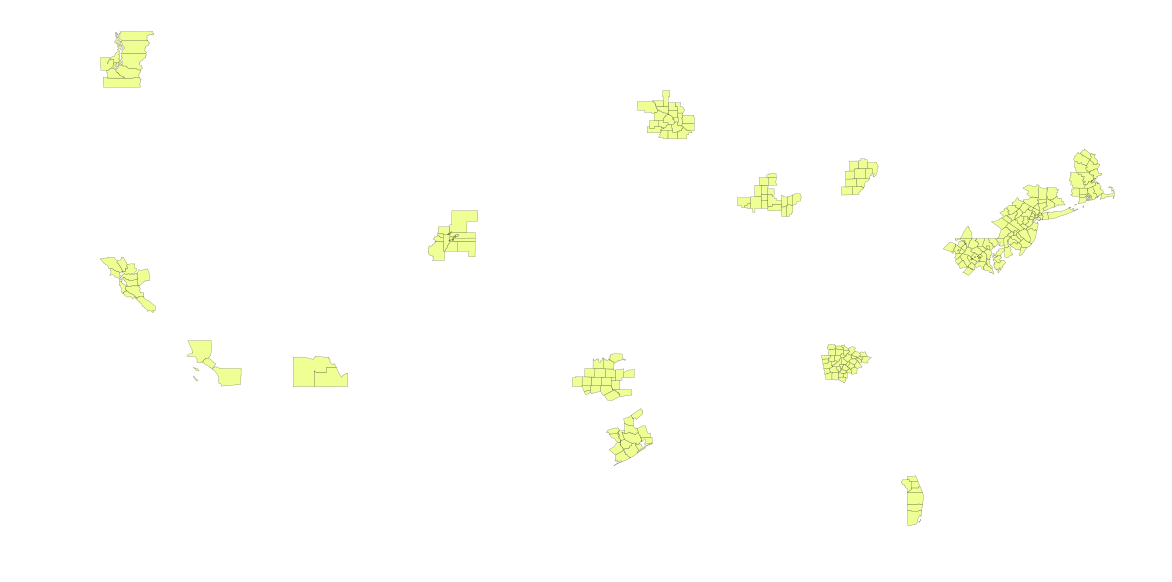

In [11]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)
USmetros.plot(ax=ax, color='#EDFF78', edgecolor='k', linewidth=.2, alpha=0.8)
tmp = ax.axis('off')

## 1.2 US CSAs

In [12]:
allCSA = gpd.GeoDataFrame.from_file('../DCP internship/cb_2017_us_csa_500k/cb_2017_us_csa_500k.shp')
print(allCSA.shape)
allCSA.head()

(174, 8)


,CSAFP,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,450,330M300US450,450,"Raleigh-Durham-Chapel Hill, NC",M0,14270829773,301833048,"POLYGON ((-79.554816 35.547456, -79.5540379999..."
1,544,330M300US544,544,"Victoria-Port Lavaca, TX",M0,5804050524,1398360729,"(POLYGON ((-96.77208399999999 28.421988, -96.7..."
2,324,330M300US324,324,"Lake Charles-Jennings, LA",M0,7771400431,1784449473,"POLYGON ((-93.929208 29.802952, -93.9279919999..."
3,548,330M300US548,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",M0,32712037570,5208979324,"(POLYGON ((-76.065444 38.129795, -76.064612999..."
4,268,330M300US268,268,"Greensboro--Winston-Salem--High Point, NC",M0,12845012068,188816451,"POLYGON ((-80.973643 36.453474, -80.968289 36...."


(174, 7)


,CSAFP,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
0,450,330M300US450,450,"Raleigh-Durham-Chapel Hill, NC",M0,14270829773,301833048
1,544,330M300US544,544,"Victoria-Port Lavaca, TX",M0,5804050524,1398360729
2,324,330M300US324,324,"Lake Charles-Jennings, LA",M0,7771400431,1784449473
3,548,330M300US548,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",M0,32712037570,5208979324
4,268,330M300US268,268,"Greensboro--Winston-Salem--High Point, NC",M0,12845012068,188816451


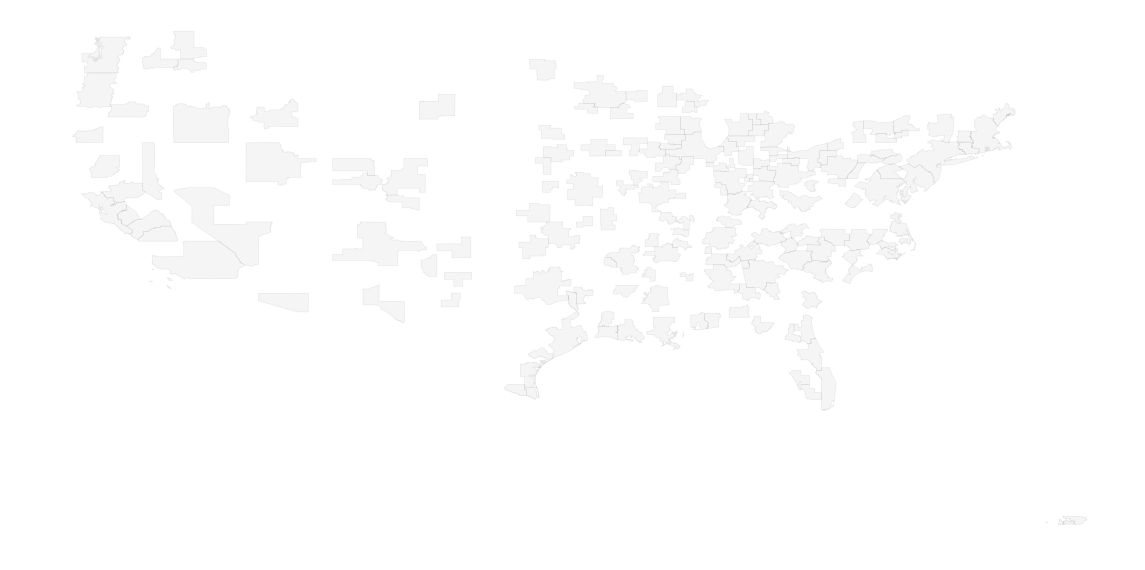

In [13]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)
allCSA.plot(ax=ax, color='grey', edgecolor='k',linewidth=.6, alpha=0.08)

ax.axis('off')

allCSA = allCSA.drop(['geometry'], axis=1)
print(allCSA.shape)
allCSA.head()

## 1.3 All US Counties .shp for assigning Counties to CSAs

In [14]:
AllCounties = gpd.GeoDataFrame.from_file('../DCP internship/tl_2017_us_county/tl_2017_us_county.shp')
AllCounties = AllCounties[['GEOID', 'NAME', 'MTFCC', 'CSAFP', 'geometry']]

print(type(AllCounties))
print(AllCounties.shape)
AllCounties.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(3233, 5)


,GEOID,NAME,MTFCC,CSAFP,geometry
0,31039,Cuming,G4020,,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,53069,Wahkiakum,G4020,,"POLYGON ((-123.436394 46.238197, -123.447592 4..."
2,35011,De Baca,G4020,,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
3,31109,Lancaster,G4020,339,"POLYGON ((-96.91059899999999 40.958407, -96.91..."
4,31129,Nuckolls,G4020,,"POLYGON ((-98.27366699999999 40.089399, -98.27..."


In [15]:
AllCounties.crs

{'init': 'epsg:4269'}

In [16]:
AllCounties.crs = {'init' :'epsg:3857'}
AllCounties.crs

{'init': 'epsg:3857'}

In [17]:
AllCounties['CSAFP'].dtypes

dtype('O')

In [18]:
AllCounties['CSAFP'][AllCounties['GEOID'] == '36105'] = '408'

AllCounties[AllCounties['GEOID'] == '36105']

,GEOID,NAME,MTFCC,CSAFP,geometry
1760,36105,Sullivan,G4020,408,"POLYGON ((-75.054131 41.73010499999999, -75.05..."


In [19]:
AllCounties.shape

(3233, 5)

### Merge with Major US counties .shp

In [20]:
print(type(USmetros))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [21]:
type(USmetros.merge(AllCounties.iloc[:,:-1], on = 'NAME'))

geopandas.geodataframe.GeoDataFrame

In [22]:
USmetros = USmetros.merge(AllCounties.iloc[:,:-1], left_on = 'STCO', right_on = 'GEOID')
USmetros = USmetros.drop(['NAME_x', 'GEOID', 'MTFCC'], axis=1)
USmetros.columns = ['SHAPE_AREA', 'SHAPE_LEN', 'STCO', 'geometry', 'NAME', 'CSAFP']

print(type(USmetros))
print(USmetros.shape)
USmetros.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(277, 6)


,SHAPE_AREA,SHAPE_LEN,STCO,geometry,NAME,CSAFP
0,3.432456e+10,951872.150986,04013,"POLYGON ((-12616263.466 4016946.415700004, -12...",Maricopa,
1,1.980515e+10,696888.142939,04021,"POLYGON ((-12490462.7566 3887572.943000004, -1...",Pinal,
2,3.124167e+09,305860.973251,06001,"POLYGON ((-13618345.0421 4551161.905000001, -1...",Alameda,488
3,3.158013e+09,300016.092481,06013,"POLYGON ((-13628818.5334 4574539.895900004, -1...",Contra Costa,488
4,1.561232e+10,781150.181506,06037,"(POLYGON ((-13240429.4019 4038872.710100003, -...",Los Angeles,348


### Merge with CSA .shp

In [23]:
CSAwCounties = USmetros.merge(allCSA, on = 'CSAFP')
CSAwCounties = CSAwCounties.drop(['SHAPE_LEN', 'AFFGEOID', 'GEOID', 'LSAD', 'ALAND', 'AWATER'], axis=1)
CSAwCounties.columns = ['SHAPE_AREA', 'STCO', 'geometry', 'County_name', 'CSA', 'CSA_name']

print(type(CSAwCounties))
print(CSAwCounties.shape)
print(CSAwCounties.geometry.name)
CSAwCounties.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(274, 6)
geometry


,SHAPE_AREA,STCO,geometry,County_name,CSA,CSA_name
0,3.124167e+09,06001,"POLYGON ((-13618345.0421 4551161.905000001, -1...",Alameda,488,"San Jose-San Francisco-Oakland, CA"
1,3.158013e+09,06013,"POLYGON ((-13628818.5334 4574539.895900004, -1...",Contra Costa,488,"San Jose-San Francisco-Oakland, CA"
2,2.298070e+09,06041,"(POLYGON ((-13694586.3189 4579361.395599999, -...",Marin,488,"San Jose-San Francisco-Oakland, CA"
3,3.344885e+09,06055,"POLYGON ((-13652937.1333 4664335.483199999, -1...",Napa,488,"San Jose-San Francisco-Oakland, CA"
4,5.596080e+09,06069,"POLYGON ((-13541348.2494 4424341.478500001, -1...",San Benito,488,"San Jose-San Francisco-Oakland, CA"


----
# **Don't run these cells -- projection incompability
### Adding miising county of NY region - county _Sullivan_ 

In [22]:
AllCounties = AllCounties.drop(['MTFCC'], axis=1)
AllCounties.columns = ['STCO', 'County_name', 'CSA', 'geometry']

print(AllCounties.shape)
AllCounties.head()

(3233, 4)


,STCO,County_name,CSA,geometry
0,31039,Cuming,,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,53069,Wahkiakum,,"POLYGON ((-123.436394 46.238197, -123.447592 4..."
2,35011,De Baca,,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
3,31109,Lancaster,339,"POLYGON ((-96.91059899999999 40.958407, -96.91..."
4,31129,Nuckolls,,"POLYGON ((-98.27366699999999 40.089399, -98.27..."


In [23]:
# Adding miising county of NY region - county Sullivan
CSAwCounties = pd.concat([CSAwCounties,AllCounties[AllCounties['STCO'] == '36105']], axis=0, ignore_index=True)

print(CSAwCounties.shape)
CSAwCounties.head()

(275, 7)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,CSA,CSA_name,County_name,SHAPE_AREA,STCO,STCOzip,geometry
0,488,"San Jose-San Francisco-Oakland, CA",Alameda,3.124167e+09,06001,"(06, 001)","POLYGON ((-13618345.0421 4551161.905000001, -1..."
1,488,"San Jose-San Francisco-Oakland, CA",Contra Costa,3.158013e+09,06013,"(06, 013)","POLYGON ((-13628818.5334 4574539.895900004, -1..."
2,488,"San Jose-San Francisco-Oakland, CA",Marin,2.298070e+09,06041,"(06, 041)","(POLYGON ((-13694586.3189 4579361.395599999, -..."
3,488,"San Jose-San Francisco-Oakland, CA",Napa,3.344885e+09,06055,"(06, 055)","POLYGON ((-13652937.1333 4664335.483199999, -1..."
4,488,"San Jose-San Francisco-Oakland, CA",San Benito,5.596080e+09,06069,"(06, 069)","POLYGON ((-13541348.2494 4424341.478500001, -1..."


In [24]:
CSAwCounties[CSAwCounties['STCO'] == '36105']

,CSA,CSA_name,County_name,SHAPE_AREA,STCO,STCOzip,geometry
274,408,NaN,Sullivan,NaN,36105,NaN,"POLYGON ((-75.054131 41.73010499999999, -75.05..."


In [25]:
CSAwCounties['geometry'][CSAwCounties['STCO'] == '36105'].area

274    0.279299
dtype: float64

In [26]:
# assigning values to NaNs

CSAwCounties['CSA_name'][CSAwCounties['STCO'] == '36105'] = 'New York-Newark, NY-NJ-CT-PA'
CSAwCounties['SHAPE_AREA'][CSAwCounties['STCO'] == '36105'] = CSAwCounties['geometry'][CSAwCounties['STCO'] == '36105'].area
CSAwCounties['STCOzip'][CSAwCounties['STCO'] == '36105'] = '(36, 105)'

CSAwCounties[CSAwCounties['STCO'] == '36105']

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,CSA,CSA_name,County_name,SHAPE_AREA,STCO,STCOzip,geometry
274,408,"New York-Newark, NY-NJ-CT-PA",Sullivan,0.279299,36105,"(36, 105)","POLYGON ((-75.054131 41.73010499999999, -75.05..."


### List of CSA's 

In [27]:
print(len(CSAwCounties['CSA'].unique()))
print(CSAwCounties['CSA'].unique())

15
['488' '348' '216' '408' '148' '428' '548' '370' '122' '176' '220' '378'
 '206' '288' '500']


### Reduce NY regionfrom 35 to 31 counties

In [28]:
NYreg = pd.read_excel('31CR-CountyCodes.xlsx')
NYreg

,StCo_Str,StCo_Num,Co,Subreg1,Subreg2,StCo_Lbl,Co_lbl
0,9001,9001,1,CT,CT,"Fairfield County, Connecticut",Fairfield
1,9005,9005,5,CT,CT,"Litchfield County, Connecticut",Litchfield
2,9009,9009,9,CT,CT,"New Haven County, Connecticut",New Haven
3,34003,34003,3,NJ In,North NJ,"Bergen County, New Jersey",Bergen
4,34013,34013,13,NJ In,North NJ,"Essex County, New Jersey",Essex
5,34017,34017,17,NJ In,North NJ,"Hudson County, New Jersey",Hudson
6,34019,34019,19,NJ Out,North NJ,"Hunterdon County, New Jersey",Hunterdon
7,34021,34021,21,NJ Out,North NJ,"Mercer County, New Jersey",Mercer
8,34023,34023,23,NJ In,North NJ,"Middlesex County, New Jersey",Middlesex
9,34025,34025,25,NJ Out,North NJ,"Monmouth County, New Jersey",Monmouth


#### _NY CSA counties that are not contained in NY Region:_

#### _removing the 5 counties that are not contained in NY Region:_

In [29]:
CSAwCounties[56:61]

,CSA,CSA_name,County_name,SHAPE_AREA,STCO,STCOzip,geometry
56,408,"New York-Newark, NY-NJ-CT-PA",Carbon,1.755351e+09,42025,"(42, 025)","POLYGON ((-8459986.081 4999515.4309, -8458722...."
57,408,"New York-Newark, NY-NJ-CT-PA",Lehigh,1.560527e+09,42077,"(42, 077)",POLYGON ((-8438884.469599999 4969292.068400003...
58,408,"New York-Newark, NY-NJ-CT-PA",Monroe,2.825647e+09,42089,"(42, 089)","POLYGON ((-8419647.2371 5030529.472099997, -84..."
59,408,"New York-Newark, NY-NJ-CT-PA",Northampton,1.694765e+09,42095,"(42, 095)","POLYGON ((-8416753.7096 4981031.695, -8413247...."
60,408,"New York-Newark, NY-NJ-CT-PA",Pike,2.605426e+09,42103,"(42, 103)",POLYGON ((-8386209.645099999 5052207.073399998...


In [30]:
CSAwCounties = CSAwCounties.drop(CSAwCounties.index[56:61])

print(CSAwCounties.shape)

(270, 7)


In [31]:
CSAwCounties[CSAwCounties['CSA'] == '408'].shape

(31, 7)

-----

In [24]:
print(len(CSAwCounties.CSA_name.unique()))
CSAwCounties.CSA_name.unique()

15


array(['San Jose-San Francisco-Oakland, CA', 'Los Angeles-Long Beach, CA',
       'Denver-Aurora, CO', 'New York-Newark, NY-NJ-CT-PA',
       'Boston-Worcester-Providence, MA-RI-NH-CT',
       'Philadelphia-Reading-Camden, PA-NJ-DE-MD',
       'Washington-Baltimore-Arlington, DC-MD-VA-WV-PA',
       'Miami-Fort Lauderdale-Port St. Lucie, FL',
       'Atlanta--Athens-Clarke County--Sandy Springs, GA',
       'Chicago-Naperville, IL-IN-WI', 'Detroit-Warren-Ann Arbor, MI',
       'Minneapolis-St. Paul, MN-WI', 'Dallas-Fort Worth, TX-OK',
       'Houston-The Woodlands, TX', 'Seattle-Tacoma, WA'], dtype=object)

In [25]:
CSAs = CSAwCounties.groupby(['CSA', 'CSA_name']).count().reset_index().set_index('CSA')
CSAs = CSAs.iloc[:,:2]
CSAs.columns = ['CSA_name', 'numberCounties']

print(CSAs.index)
print(CSAs.shape)
CSAs

Index(['122', '148', '176', '206', '216', '220', '288', '348', '370', '378',
       '408', '428', '488', '500', '548'],
      dtype='object', name='CSA')
(15, 2)


,CSA_name,numberCounties
CSA,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",39
148,"Boston-Worcester-Providence, MA-RI-NH-CT",19
176,"Chicago-Naperville, IL-IN-WI",18
206,"Dallas-Fort Worth, TX-OK",20
216,"Denver-Aurora, CO",12
220,"Detroit-Warren-Ann Arbor, MI",10
288,"Houston-The Woodlands, TX",14
348,"Los Angeles-Long Beach, CA",2
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",7


In [26]:
CSAs['CSA_short'] = CSAs['CSA_name'].str.split('-').str[0]
CSAs['CSA_short'] = CSAs['CSA_short'].replace(['San Jose'], ['San Francisco']) 

CSAs

,CSA_name,numberCounties,CSA_short
CSA,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",39,Atlanta
148,"Boston-Worcester-Providence, MA-RI-NH-CT",19,Boston
176,"Chicago-Naperville, IL-IN-WI",18,Chicago
206,"Dallas-Fort Worth, TX-OK",20,Dallas
216,"Denver-Aurora, CO",12,Denver
220,"Detroit-Warren-Ann Arbor, MI",10,Detroit
288,"Houston-The Woodlands, TX",14,Houston
348,"Los Angeles-Long Beach, CA",2,Los Angeles
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",7,Miami


(-14050055.802375002,
 -7486012.8163250005,
 2730485.8160950006,
 6382973.441805003)

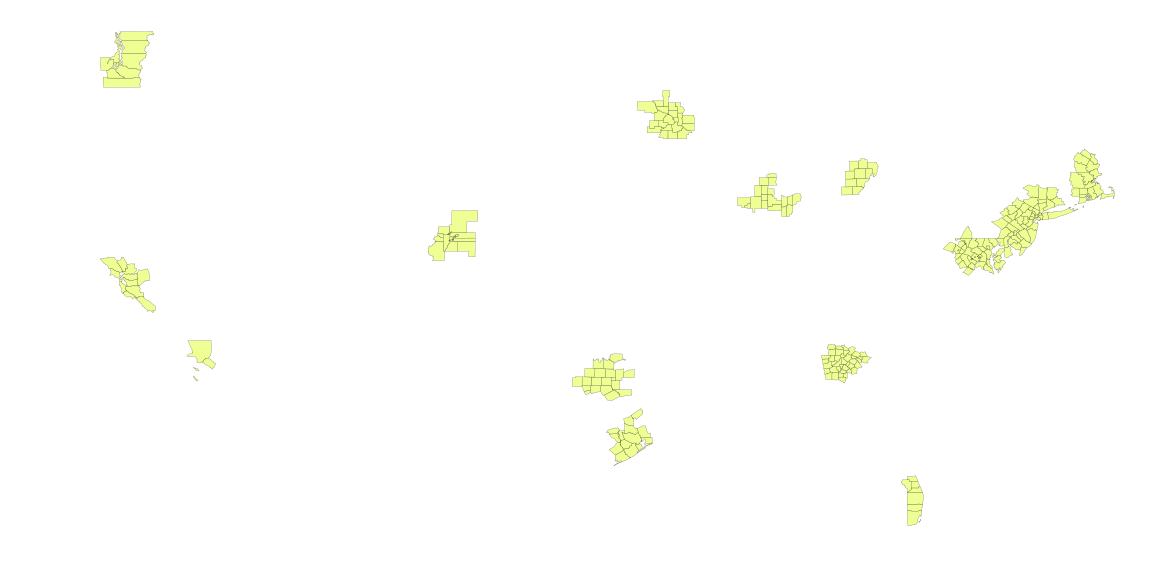

In [27]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)

CSAwCounties.plot(ax=ax, color='#EDFF78', edgecolor='k',linewidth=.2, alpha=0.8);

ax.axis('off')
# print(CSAwCounties['NAME'][CSAwCounties['CSAFP'] == '348'])

In [28]:
CSAs['CSA_name'][CSAs.index[0]]

'Atlanta--Athens-Clarke County--Sandy Springs, GA'

In [31]:
CSAs_sorted = ['500','216', '220','378','148',
               '488','176',  '122','548','408',
               '348', '206', '288', '428', '370']

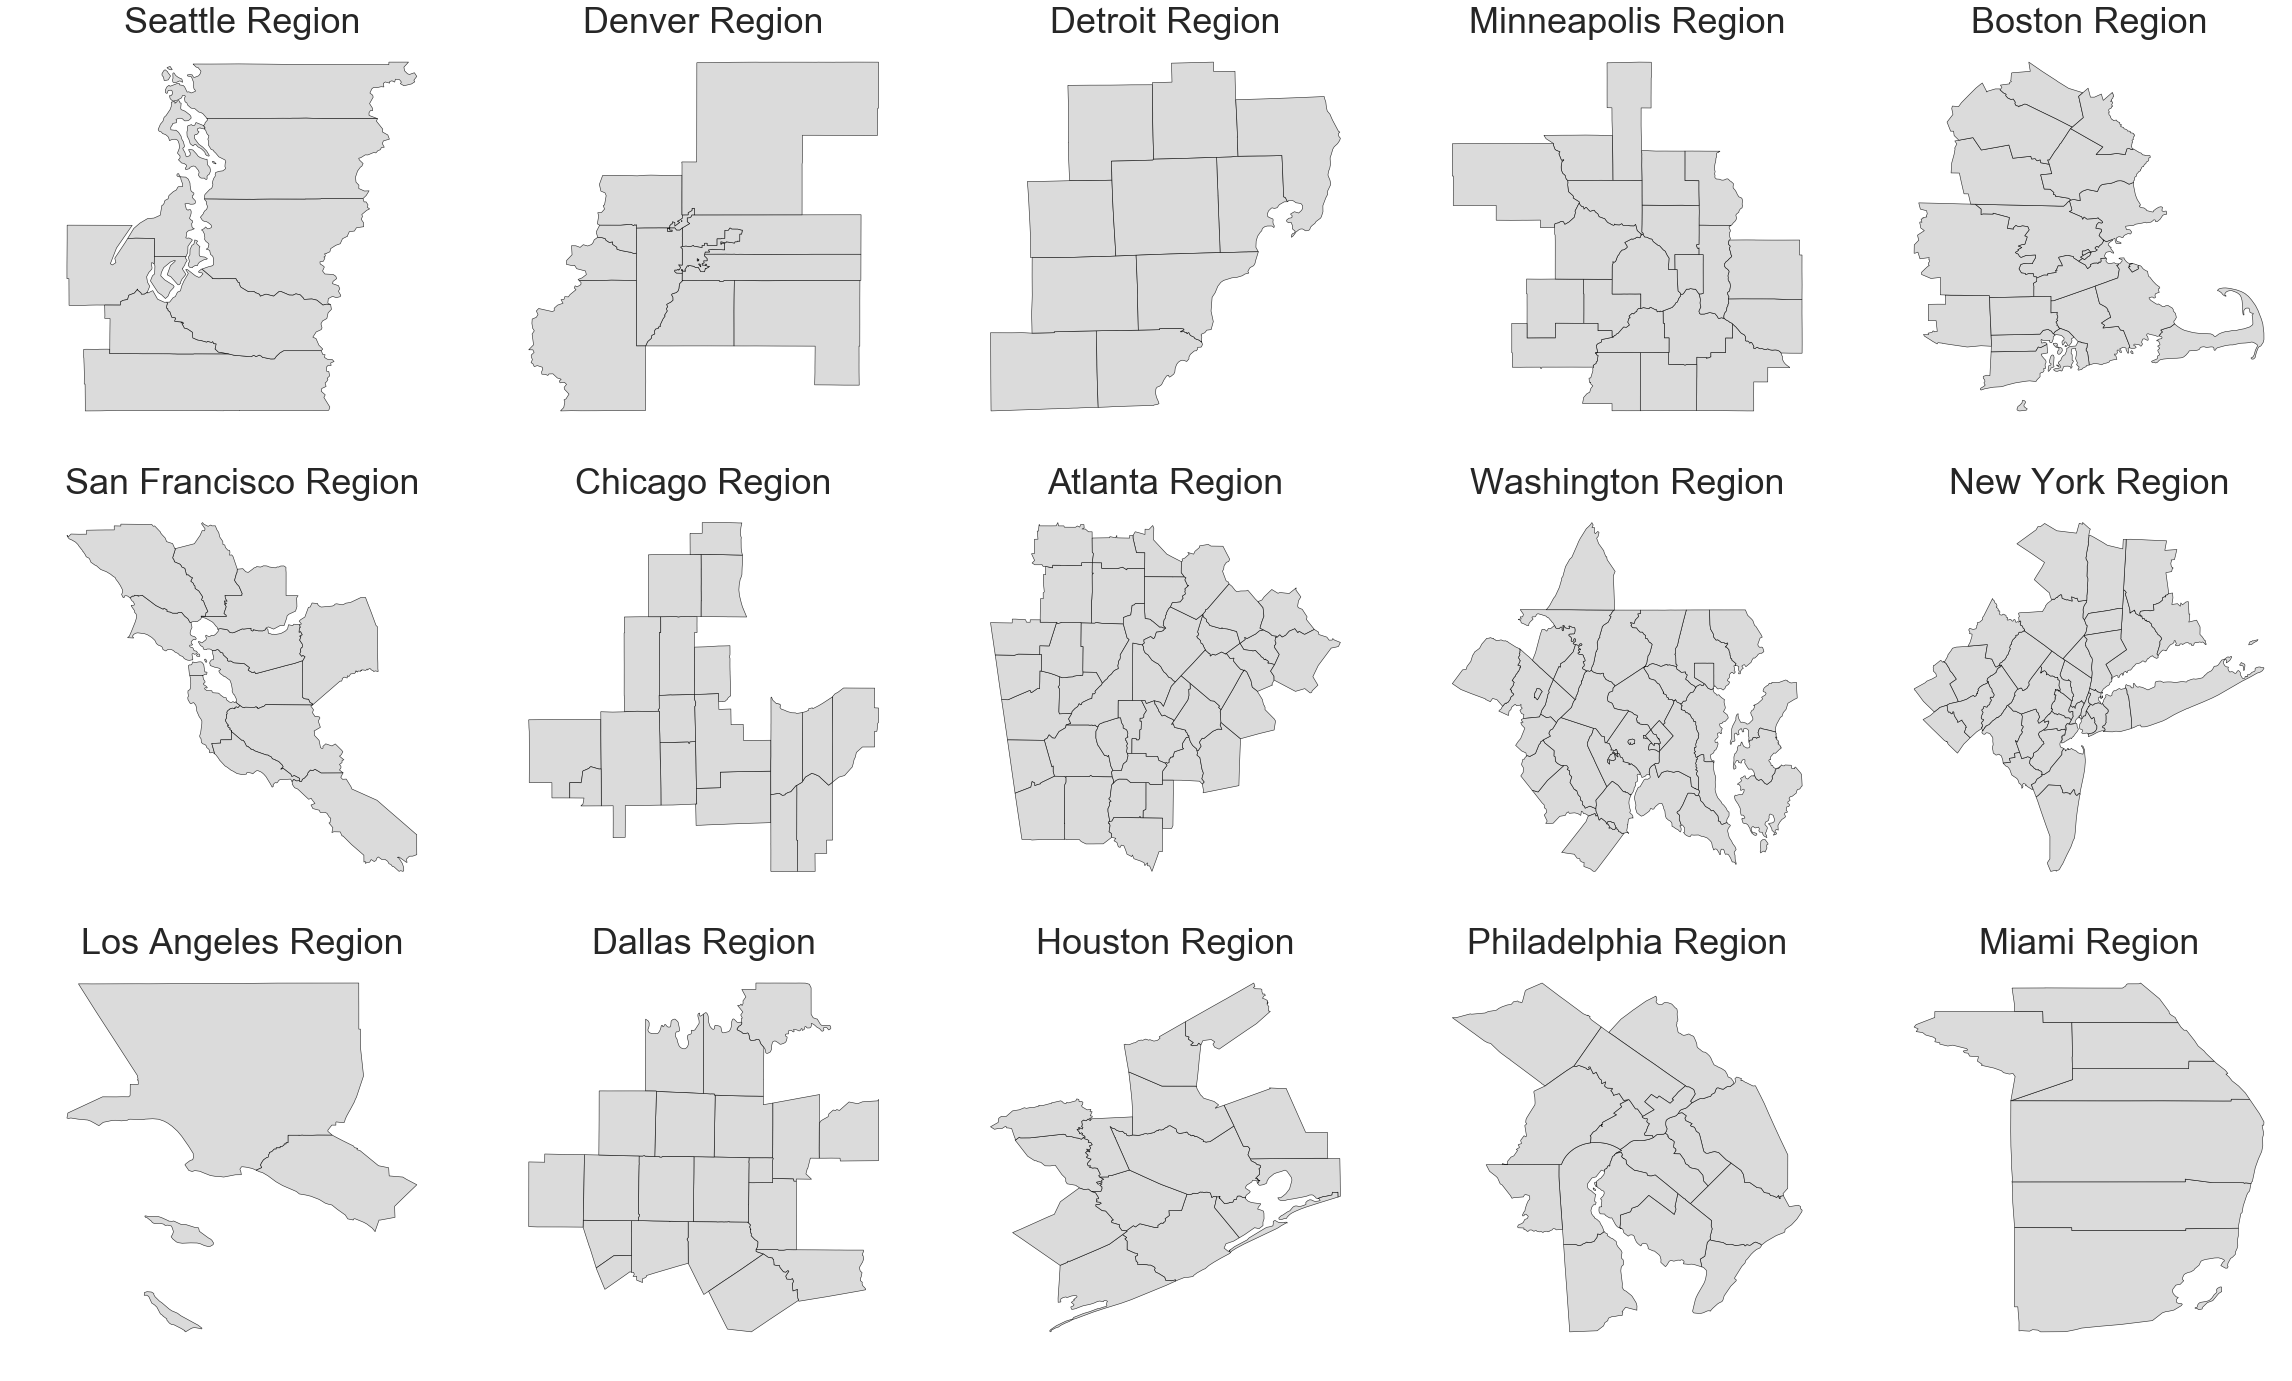

In [35]:
from matplotlib.colorbar import ColorbarBase

fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 4000

# cax = fig.add_axes([0.1, 0.92, .85, 0.015])
# sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# fig.colorbar(sm, cax=cax, orientation='horizontal')

# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    CSAwCounties[CSAwCounties['CSA'] == CSAs_sorted[k]].plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')

In [30]:
# exporting the above as .csv for later plotting; 
# NYC Metro: no Sullivan County, extra 5 counties 
CSAwCounties.to_file("exports/USmetros_rawNYC.shp")
# CSAwCounties.to_csv('USmetros_rawNYC.csv')

----

## ** _EXTRA_ US border plot

In [38]:
# US map
allUSshp = gpd.GeoDataFrame.from_file('cb_2017_us_state_500k/cb_2017_us_state_500k.shp')
allUSshp.crs = {'init' :'epsg:2263'}
allUSshp.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,54,01779805,0400000US54,54,WV,West Virginia,00,62265662566,489840834,"POLYGON ((-82.6431981036679 38.1690897960737, ..."
1,17,01779784,0400000US17,17,IL,Illinois,00,143784114293,6211277447,"POLYGON ((-91.512974 40.181062, -91.511073 40...."
2,24,01714934,0400000US24,24,MD,Maryland,00,25150696145,6980371026,"(POLYGON ((-76.05015299999999 37.986905, -76.0..."
3,16,01779783,0400000US16,16,ID,Idaho,00,214048160737,2393355752,"POLYGON ((-117.242675 44.396548, -117.234835 4..."
4,50,01779802,0400000US50,50,VT,Vermont,00,23873457570,1031134839,"POLYGON ((-73.43773999999999 44.045006, -73.43..."


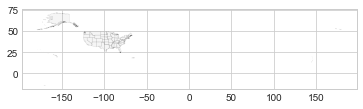

In [39]:
allUSshp.plot(color='grey', edgecolor='k',linewidth=.6, alpha=0.08)

-----

# EXPORTING .shp of 15 Major Metros of the analysis

In [40]:
CSAwCounties[:-1]

,CSA,CSA_name,County_name,SHAPE_AREA,STCO,STCOzip,geometry
0,488,"San Jose-San Francisco-Oakland, CA",Alameda,3.124167e+09,06001,"(06, 001)","POLYGON ((-13618345.0421 4551161.905000001, -1..."
1,488,"San Jose-San Francisco-Oakland, CA",Contra Costa,3.158013e+09,06013,"(06, 013)","POLYGON ((-13628818.5334 4574539.895900004, -1..."
2,488,"San Jose-San Francisco-Oakland, CA",Marin,2.298070e+09,06041,"(06, 041)","(POLYGON ((-13694586.3189 4579361.395599999, -..."
3,488,"San Jose-San Francisco-Oakland, CA",Napa,3.344885e+09,06055,"(06, 055)","POLYGON ((-13652937.1333 4664335.483199999, -1..."
4,488,"San Jose-San Francisco-Oakland, CA",San Benito,5.596080e+09,06069,"(06, 069)","POLYGON ((-13541348.2494 4424341.478500001, -1..."
5,488,"San Jose-San Francisco-Oakland, CA",San Francisco,2.003099e+08,06075,"(06, 075)","(POLYGON ((-13638249.8624 4548510.4001, -13637..."
6,488,"San Jose-San Francisco-Oakland, CA",San Joaquin,5.943382e+09,06077,"(06, 077)","POLYGON ((-13534468.9275 4589096.202299997, -1..."
7,488,"San Jose-San Francisco-Oakland, CA",San Mateo,1.899909e+09,06081,"(06, 081)","POLYGON ((-13638807.6722 4514280.979199998, -1..."
8,488,"San Jose-San Francisco-Oakland, CA",Santa Clara,5.334077e+09,06085,"(06, 085)","POLYGON ((-13603537.1055 4489832.2557, -136034..."
9,488,"San Jose-San Francisco-Oakland, CA",Santa Cruz,1.821667e+09,06087,"(06, 087)","POLYGON ((-13616342.0753 4465196.642399997, -1..."


In [41]:
# 1. with Sullivan County
CSAwCounties.to_csv('USmetros_full.csv')

# 2. WO Sullivan County
CSAwCounties[:-1].to_csv('USmetros_notfull.csv')

-----

# Assigning census tracts to Counties-CSAs

In [42]:
tractsGeo = pd.read_excel('data/ALL Tract Geo Codes.xlsx')
print(tractsGeo.shape)
tractsGeo.head(10)

(28066, 5)


,TRACT,CSA,STCO,ST,CO
0,10001041600,428,10001,10,1
1,10003001300,428,10003,10,3
2,10003011100,428,10003,10,3
3,10003011600,428,10003,10,3
4,10003013200,428,10003,10,3
5,10003014200,428,10003,10,3
6,10003015400,428,10003,10,3
7,10003016301,428,10003,10,3
8,10003980100,428,10003,10,3
9,10001040700,428,10001,10,1


In [ ]:
# download and clean census tract shp
# or from dara -- cleaned ArcMap exports

-----

# 2 - Census Data acquisition

In [43]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI

In [44]:
import json
import requests 
import urllib

#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2017/pep/population/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [45]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

In [46]:
affkeys

array(['CONCIT', 'CBSA', 'POP', 'NATION', 'PLACE', 'REGION', 'CSA',
       'DATE_DESC', 'for', 'COUNTY', 'in', 'UNIVERSE', 'GEONAME', 'DATE',
       'DENSITY', 'SUMLEV', 'DIVISION', 'LASTUPDATE', 'PRIMGEOFLAG',
       'COUSUB', 'STATE', 'FUNCSTAT', 'MDIV'], dtype='<U11')

In [47]:
# keyword for POP estimates
POP = 'POP'

aff1y['variables'][POP]

{'concept': 'Estimates',
 'group': 'N/A',
 'label': 'Population',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

## POPULATION 2017

In [44]:
# total POP for all counties in the US
POP17 = pd.read_json('https://api.census.gov/data/2017/pep/population?get=POP,GEONAME&for=county:*')
POP17.columns = POP17.iloc[0]
POP17 = POP17[1:]
POP17['STCOzip']=list(zip(POP17.state, POP17.county))

print(POP17.shape)
POP17.head()

(3220, 5)


,POP,GEONAME,state,county,STCOzip
1,55504,"Autauga County, Alabama",01,001,"(01, 001)"
2,212628,"Baldwin County, Alabama",01,003,"(01, 003)"
3,25270,"Barbour County, Alabama",01,005,"(01, 005)"
4,22668,"Bibb County, Alabama",01,007,"(01, 007)"
5,58013,"Blount County, Alabama",01,009,"(01, 009)"


----

In [38]:
POP15 = pd.read_json('https://api.census.gov/data/2015/pep/population?get=POP,GEONAME&for=county:*')
POP15.columns = POP15.iloc[0]
POP15 = POP15[1:]
# POP17['STCOzip']=list(zip(POP17.state, POP17.county))

print(POP15.shape)
POP15.head()

(3220, 4)


,POP,GEONAME,state,county
1,55347,"Autauga County, Alabama, East South Central, S...",01,001
2,203709,"Baldwin County, Alabama, East South Central, S...",01,003
3,26489,"Barbour County, Alabama, East South Central, S...",01,005
4,22583,"Bibb County, Alabama, East South Central, Sout...",01,007
5,57673,"Blount County, Alabama, East South Central, So...",01,009


In [39]:
POP15[POP15['state'] == '34'].sort_values('POP', ascending=False)

,POP,GEONAME,state,county
1779,94727,"Cape May County, New Jersey, Middle Atlantic, ...",34,009
1776,938506,"Bergen County, New Jersey, Middle Atlantic, No...",34,003
1786,840900,"Middlesex County, New Jersey, Middle Atlantic,...",34,023
1781,797434,"Essex County, New Jersey, Middle Atlantic, Nor...",34,013
1783,674836,"Hudson County, New Jersey, Middle Atlantic, No...",34,017
1791,64180,"Salem County, New Jersey, Middle Atlantic, Nor...",34,033
1787,628715,"Monmouth County, New Jersey, Middle Atlantic, ...",34,025
1789,588721,"Ocean County, New Jersey, Middle Atlantic, Nor...",34,029
1794,555786,"Union County, New Jersey, Middle Atlantic, Nor...",34,039
1778,510923,"Camden County, New Jersey, Middle Atlantic, No...",34,007


----

In [40]:
# total POP for all places in the US
POP17place = pd.read_json('https://api.census.gov/data/2017/pep/population?get=POP,GEONAME&for=place:*')
# POP17place.columns = POP17.iloc[0]
POP17place = POP17place[1:]
# POP17place['STCOzip']=list(zip(POP17place.state, POP17.place))

print(POP17place.shape)
POP17place.head()

(19500, 4)


,0,1,2,3
1,2567,"Abbeville city, Alabama",01,00124
2,4347,"Adamsville city, Alabama",01,00460
3,728,"Addison town, Alabama",01,00484
4,332,"Akron town, Alabama",01,00676
5,33202,"Alabaster city, Alabama",01,00820


In [45]:
POP17shp = CSAwCounties.merge(POP17, on = 'STCOzip')
POP17shp = POP17shp.drop(['GEONAME', 'state', 'county'], axis=1)


print(POP17shp.shape)
POP17shp.head()

KeyError: 'STCOzip'

In [42]:
POP17shp.dtypes

NameError: name 'POP17shp' is not defined

In [43]:
POP17shp['POP'] = POP17shp['POP'].astype('float64')
POP17shp.dtypes

NameError: name 'POP17shp' is not defined

In [52]:
POP17shp['POPsqml'] = (POP17shp['POP'] / POP17shp['SHAPE_AREA'] * 1000000)
POP17shp.head()

,SHAPE_AREA,STCO,geometry,STCOzip,County_name,CSA,CSA_name,POP,POPsqml
0,3.124167e+09,06001,"POLYGON ((-13618345.0421 4551161.905000001, -1...","(06, 001)",Alameda,488,"San Jose-San Francisco-Oakland, CA",1663190.0,532.362732
1,3.158013e+09,06013,"POLYGON ((-13628818.5334 4574539.895900004, -1...","(06, 013)",Contra Costa,488,"San Jose-San Francisco-Oakland, CA",1147439.0,363.342084
2,2.298070e+09,06041,"(POLYGON ((-13694586.3189 4579361.395599999, -...","(06, 041)",Marin,488,"San Jose-San Francisco-Oakland, CA",260955.0,113.553986
3,3.344885e+09,06055,"POLYGON ((-13652937.1333 4664335.483199999, -1...","(06, 055)",Napa,488,"San Jose-San Francisco-Oakland, CA",140973.0,42.145842
4,5.596080e+09,06069,"POLYGON ((-13541348.2494 4424341.478500001, -1...","(06, 069)",San Benito,488,"San Jose-San Francisco-Oakland, CA",60310.0,10.777187


In [53]:
POP17shp.dtypes

SHAPE_AREA     float64
STCO            object
geometry        object
STCOzip         object
County_name     object
CSA             object
CSA_name        object
POP            float64
POPsqml        float64
dtype: object

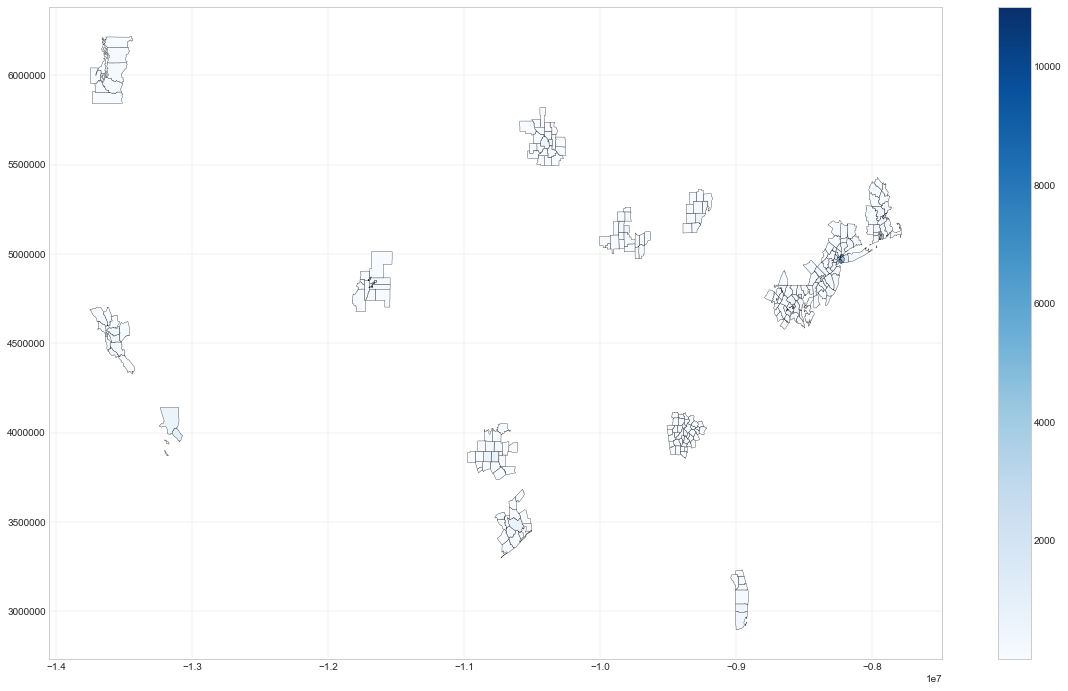

In [56]:
fig = pl.figure(figsize=(20,12))
ax = fig.add_subplot(111)

POP17shp.plot(ax=ax, column= 'POPsqml', cmap='Blues',
              legend=True, edgecolor='k', linewidth=.3);
ax.grid(linewidth=0.25)

In [57]:
print(len(POP17shp.CSA_name.unique()))
POP17shp.CSA_name.unique()

15


array(['San Jose-San Francisco-Oakland, CA', 'Los Angeles-Long Beach, CA',
       'Denver-Aurora, CO', 'New York-Newark, NY-NJ-CT-PA',
       'Boston-Worcester-Providence, MA-RI-NH-CT',
       'Philadelphia-Reading-Camden, PA-NJ-DE-MD',
       'Washington-Baltimore-Arlington, DC-MD-VA-WV-PA',
       'Miami-Fort Lauderdale-Port St. Lucie, FL',
       'Atlanta--Athens-Clarke County--Sandy Springs, GA',
       'Chicago-Naperville, IL-IN-WI', 'Detroit-Warren-Ann Arbor, MI',
       'Minneapolis-St. Paul, MN-WI', 'Dallas-Fort Worth, TX-OK',
       'Houston-The Woodlands, TX', 'Seattle-Tacoma, WA'], dtype=object)

In [58]:
len(POP17shp[POP17shp['CSA'] == '408'])

30

In [59]:
def plotRegions(column):
    ax = fig.add_subplot(3,5,k+1)
    POP17shp[POP17shp['CSA'] == CSAs.index[k]].plot(ax=ax, column=POP, cmap='Blues',
                                           edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs.index[k]]), fontsize=32, y=1.01)
    ax.grid(linewidth=0.25)

NameError: name 'POP17shp' is not defined

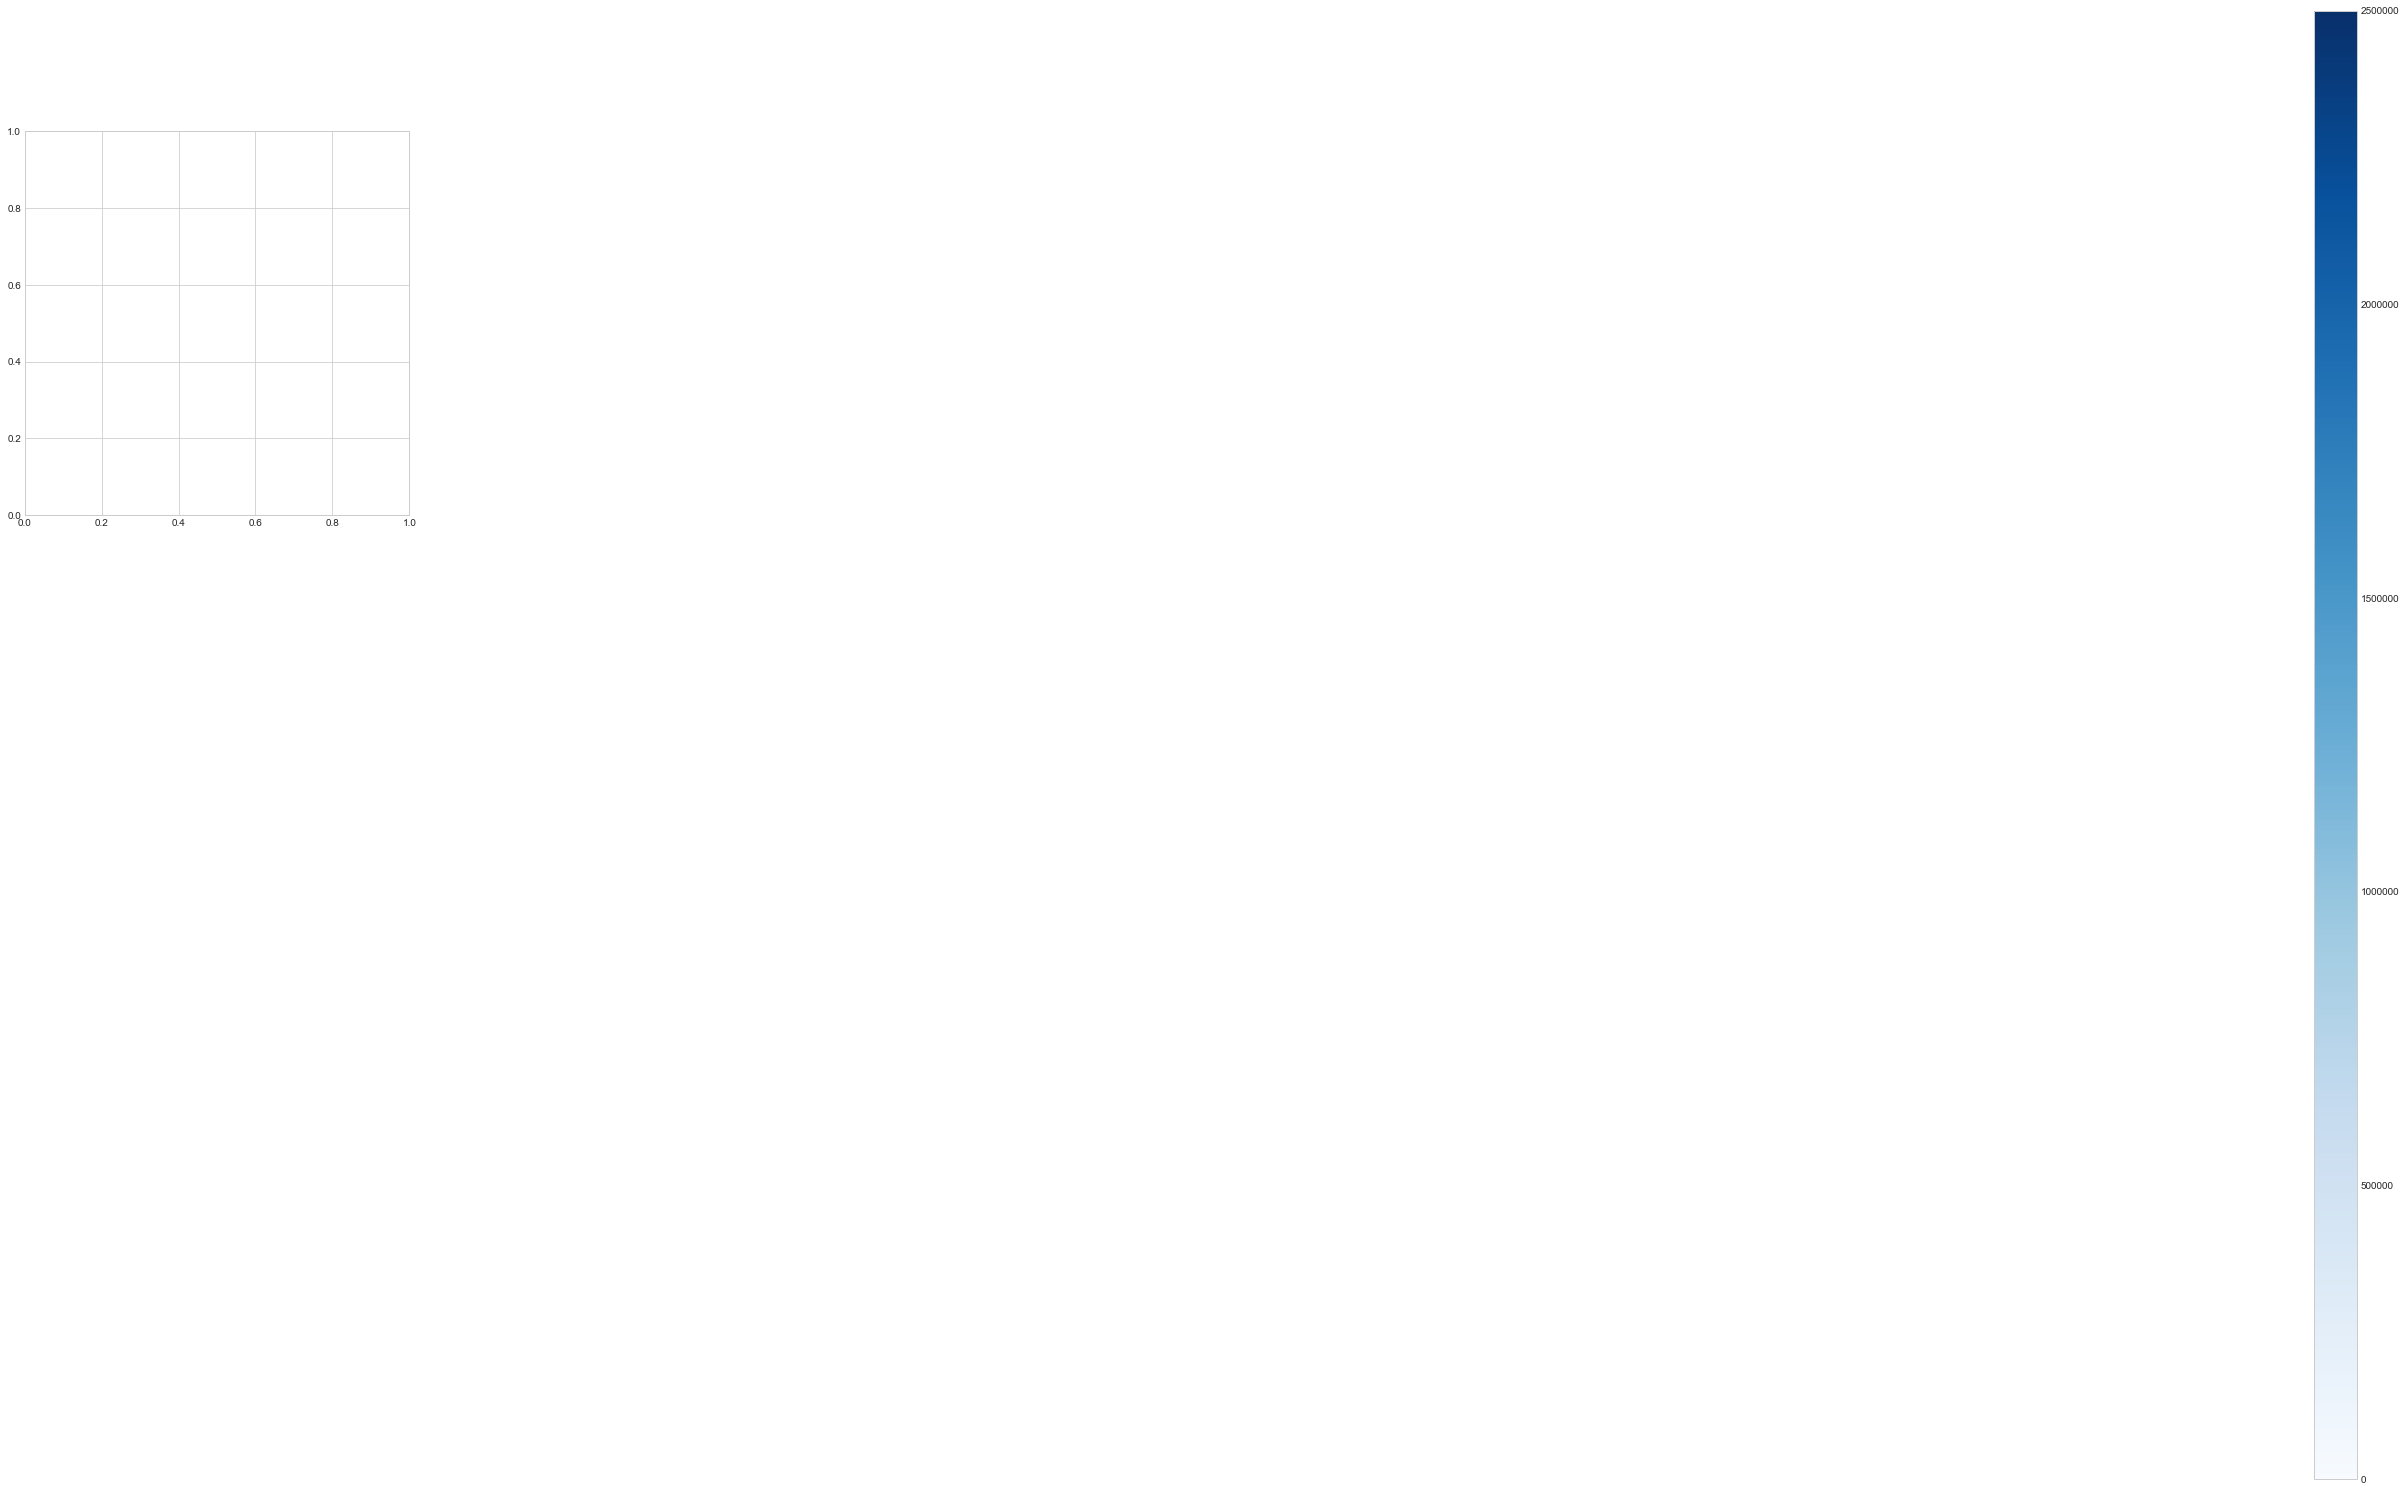

In [36]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 2500000

cax = fig.add_axes([0.92, 0.1, 0.015, .85])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical')


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    POP17shp[POP17shp['CSA'] == CSAs_sorted[k]].plot(ax=ax, column=POP, cmap='Blues',
                                           edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sortedx[k]]), fontsize=32, y=1.01)
    ax.grid(linewidth=0.25)
    ax.axis('off')

----

## _PLACES -- delete_

In [61]:
places = pd.read_excel('sub-est2017_all.xlsx')
print(places.shape)
places.head()

(81546, 20)


,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017
0,40,1,0,0,0,0,0,A,Alabama,Alabama,4779736,4780135,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
1,162,1,0,124,0,0,0,A,Abbeville city,Alabama,2688,2688,2684,2677,2629,2612,2595,2587,2575,2567
2,162,1,0,460,0,0,0,A,Adamsville city,Alabama,4522,4522,4516,4502,4479,4457,4437,4409,4376,4347
3,162,1,0,484,0,0,0,A,Addison town,Alabama,758,754,751,751,744,743,740,734,734,728
4,162,1,0,676,0,0,0,A,Akron town,Alabama,356,356,355,345,345,341,337,335,332,332


# 2. Analysis 
# _2.1 Pop 2017_

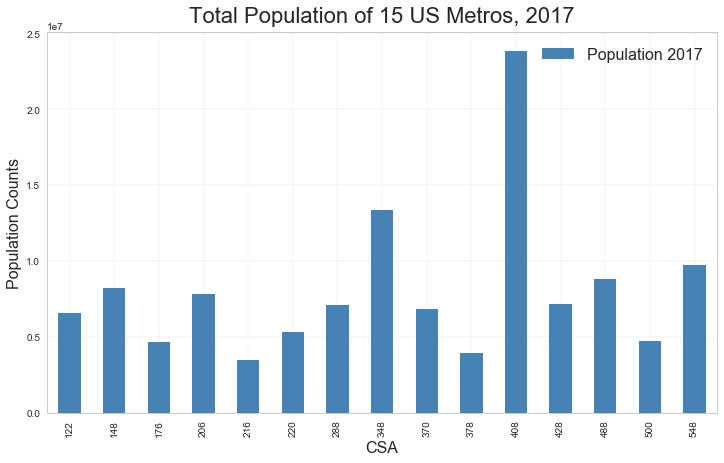

In [608]:
fig = pl.figure(figsize(12,7))

(POP17shp['POP'].groupby([POP17shp['CSA']]).sum()).plot(kind="bar", color='SteelBlue', label='Population 2017')

pl.xlabel('CSA', fontsize=16)
pl.ylabel('Population Counts', fontsize=16)
pl.title('Total Population of 15 US Metros, 2017', fontsize=22, y=1.01)
pl.legend(prop={'size': 16})
pl.grid(linewidth=0.25)

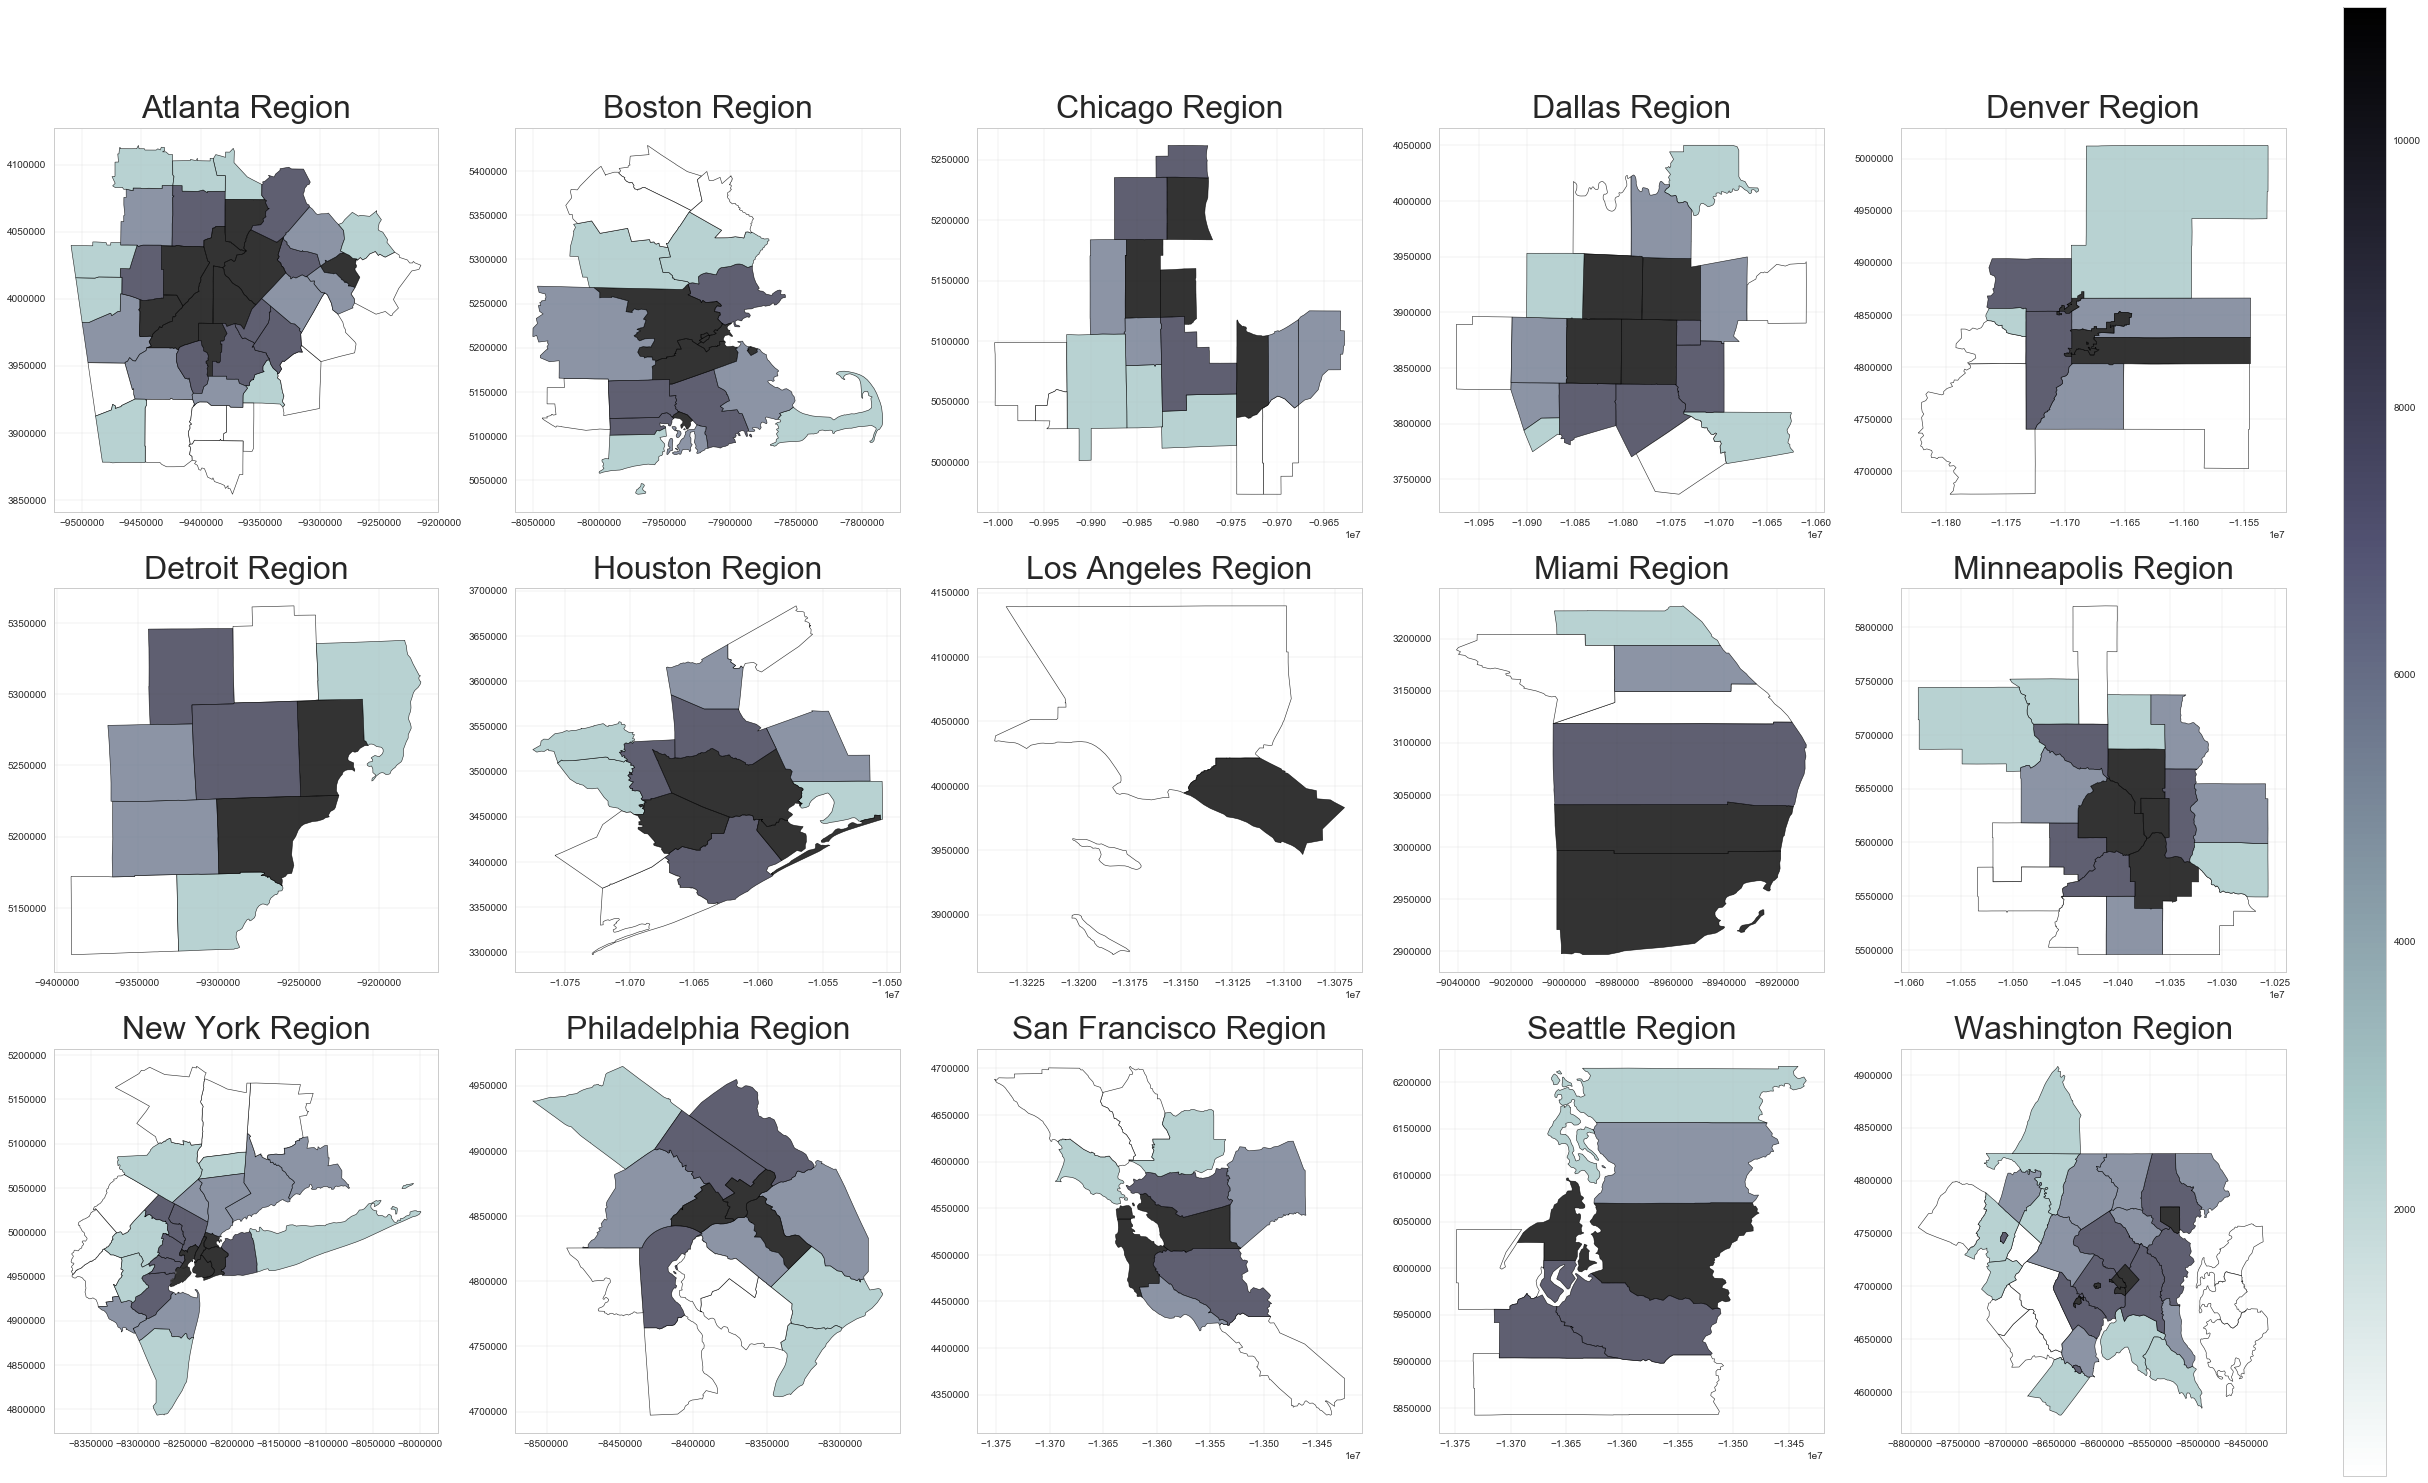

In [1088]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = POP17shp['POPsqml'].min(), POP17shp['POPsqml'].max()

cax = fig.add_axes([0.92, 0.1, 0.015, .85])
sm = plt.cm.ScalarMappable(cmap='bone_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical')

# im = axes[0].imshow(my_image1)
# clim=im.properties()['clim']
# axes[1].imshow(my_image2, clim=clim)
# fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)

# 15 choroplets of 15 major US metros
for k in range(len(CSAs.index)):
    ax = fig.add_subplot(3,5,k+1)
    POP17shp[POP17shp['CSA'] == CSAs.index[k]].plot(ax=ax, column= 'POPsqml', clim=sm, cmap='bone_r',
                            scheme='quantiles', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs.index[k]]), fontsize=32, y=1.01)
    ax.grid(linewidth=0.25)
    
plt.savefig("POPdens17.pdf", transparent=True)

## POP change 2010-2017

Data were dowload and cleaned by Dara Goldberg, Regional Planning DCP

In [676]:
POPchg1017 = pd.read_excel('CSA Population+Change_2010-2017.xlsx', skiprows=[0,2,4])[:17]
POPchg1017.columns = ['CSA', 'Name', 'FullName', 'Dec', 'Est', '2010', '2011', '2012', '2013', '2014',
                     '2015', '2016', '2017', 'dropme', '2010-2015', '2010-2016', '2010-2017', '2010-2017_An',
                     'Compare_to_US', 'Change16v17', 'dropme', 'dropme', '2010-2015.1', '2010-2016.1', '2010-2017.1']

POPchg1017 = POPchg1017.drop(['dropme'], axis=1)
POPchg1017 = pd.concat([POPchg1017[:15], POPchg1017[16:]])
# print(POPchg1017.shape)
POPchg1017

,CSA,Name,FullName,Dec,Est,2010,2011,2012,2013,2014,...,2017,2010-2015,2010-2016,2010-2017,2010-2017_An,Compare_to_US,Change16v17,2010-2015.1,2010-2016.1,2010-2017.1
0,408.0,NYC Metro,"New York-Newark, NY-NJ-CT-PA",23076664,23076853.0,23118307.0,23292725.0,23434849.0,23565018.0,23672464.0,...,23876155.0,0.029683,0.032315,0.034645,0.004779,Slower,0.002330,643348.0,704088.0,757848.0
1,122.0,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, GA",5910296,5910318.0,5928394.0,6002334.0,6084684.0,6154916.0,6247629.0,...,6555956.0,0.075168,0.092511,0.109243,0.015068,Faster,0.016732,426168.0,528671.0,627562.0
2,378.0,Minneapolis,"Minneapolis-St. Paul, MN-WI",NaN,3684926.0,3691451.0,3725607.0,3759273.0,3796534.0,3832863.0,...,3946533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,148.0,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT",7893376,7893712.0,7909845.0,7956343.0,8006386.0,8058931.0,8110878.0,...,8233270.0,0.032716,0.037381,0.043061,0.005939,Slower,0.005679,241773.0,278595.0,323425.0
4,176.0,Chicago,"Chicago-Naperville, IL-IN-WI",9840929,9841356.0,9850971.0,9876059.0,9903160.0,9924405.0,9935333.0,...,9901711.0,0.008986,0.007653,0.006176,0.000852,Slower,-0.001477,78385.0,65273.0,50740.0
5,206.0,Dallas,"Dallas-Fort Worth, TX-OK",6851398,6851525.0,6877607.0,6998442.0,7133700.0,7245440.0,7381898.0,...,7846293.0,0.099866,0.122831,0.145211,0.020029,Faster,0.022379,658015.0,815358.0,968686.0
6,216.0,Denver,"Denver-Aurora, CO",3090874,3091003.0,3104511.0,3158675.0,3214933.0,3275861.0,3337916.0,...,3515374.0,0.103106,0.121775,0.137340,0.018943,Faster,0.015565,305050.0,362753.0,410863.0
7,220.0,Detroit,"Detroit-Warren-Ann Arbor, MI",5318744,5319084.0,5313295.0,5310397.0,5314748.0,5317567.0,5323162.0,...,5336286.0,0.000621,0.001545,0.003298,0.000455,Slower,0.001753,8754.0,13666.0,22991.0
8,288.0,Houston,"Houston-The Woodlands, TX",6114562,6114704.0,6142080.0,6252940.0,6378210.0,6525212.0,6693117.0,...,7093190.0,0.122308,0.144448,0.160049,0.022076,Faster,0.015601,720342.0,855716.0,951110.0
9,348.0,Los Angeles,"Los Angeles-Long Beach, CA",17877006,17877317.0,17910139.0,18068724.0,18218086.0,18350566.0,18479970.0,...,18788800.0,0.040757,0.046205,0.051004,0.007035,Slower,0.004799,695484.0,792871.0,878661.0


In [688]:
POPchg1017['CSA'] = POPchg1017['CSA'].astype('str')
POPchg1017['CSA'] = POPchg1017['CSA'].str.slice(0,3)

POPchg1017.head()

,CSA,Name,FullName,Dec,Est,2010,2011,2012,2013,2014,...,2017,2010-2015,2010-2016,2010-2017,2010-2017_An,Compare_to_US,Change16v17,2010-2015.1,2010-2016.1,2010-2017.1
0,408,NYC Metro,"New York-Newark, NY-NJ-CT-PA",23076664,23076853.0,23118307.0,23292725.0,23434849.0,23565018.0,23672464.0,...,23876155.0,0.029683,0.032315,0.034645,0.004779,Slower,0.002330,643348.0,704088.0,757848.0
1,122,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, GA",5910296,5910318.0,5928394.0,6002334.0,6084684.0,6154916.0,6247629.0,...,6555956.0,0.075168,0.092511,0.109243,0.015068,Faster,0.016732,426168.0,528671.0,627562.0
2,378,Minneapolis,"Minneapolis-St. Paul, MN-WI",NaN,3684926.0,3691451.0,3725607.0,3759273.0,3796534.0,3832863.0,...,3946533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,148,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT",7893376,7893712.0,7909845.0,7956343.0,8006386.0,8058931.0,8110878.0,...,8233270.0,0.032716,0.037381,0.043061,0.005939,Slower,0.005679,241773.0,278595.0,323425.0
4,176,Chicago,"Chicago-Naperville, IL-IN-WI",9840929,9841356.0,9850971.0,9876059.0,9903160.0,9924405.0,9935333.0,...,9901711.0,0.008986,0.007653,0.006176,0.000852,Slower,-0.001477,78385.0,65273.0,50740.0


In [689]:
POPchg1017shp = POP17shp.merge(POPchg1017, on = 'CSA')
# POP17shp = POP17shp.drop(['GEONAME', 'state', 'county'], axis=1)


print(POPchg1017shp.shape)
POPchg1017shp.head()

(274, 30)


,SHAPE_AREA,STCO,geometry,STCOzip,County_name,CSA,CSA_name,POP,POPsqml,Name,...,2017,2010-2015,2010-2016,2010-2017,2010-2017_An,Compare_to_US,Change16v17,2010-2015.1,2010-2016.1,2010-2017.1
0,3.124167e+09,06001,"POLYGON ((-13618345.0421 4551161.905000001, -1...","(06, 001)",Alameda,488,"San Jose-San Francisco-Oakland, CA",1663190.0,532.362732,San Francisco,...,8837789.0,0.068481,0.077459,0.0839,0.011572,Faster,0.00644,538980.0,612189.0,664701.0
1,3.158013e+09,06013,"POLYGON ((-13628818.5334 4574539.895900004, -1...","(06, 013)",Contra Costa,488,"San Jose-San Francisco-Oakland, CA",1147439.0,363.342084,San Francisco,...,8837789.0,0.068481,0.077459,0.0839,0.011572,Faster,0.00644,538980.0,612189.0,664701.0
2,2.298070e+09,06041,"(POLYGON ((-13694586.3189 4579361.395599999, -...","(06, 041)",Marin,488,"San Jose-San Francisco-Oakland, CA",260955.0,113.553986,San Francisco,...,8837789.0,0.068481,0.077459,0.0839,0.011572,Faster,0.00644,538980.0,612189.0,664701.0
3,3.344885e+09,06055,"POLYGON ((-13652937.1333 4664335.483199999, -1...","(06, 055)",Napa,488,"San Jose-San Francisco-Oakland, CA",140973.0,42.145842,San Francisco,...,8837789.0,0.068481,0.077459,0.0839,0.011572,Faster,0.00644,538980.0,612189.0,664701.0
4,5.596080e+09,06069,"POLYGON ((-13541348.2494 4424341.478500001, -1...","(06, 069)",San Benito,488,"San Jose-San Francisco-Oakland, CA",60310.0,10.777187,San Francisco,...,8837789.0,0.068481,0.077459,0.0839,0.011572,Faster,0.00644,538980.0,612189.0,664701.0


In [694]:
POPchg1017shp['2010-2017'].max()

0.16004874919904319

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


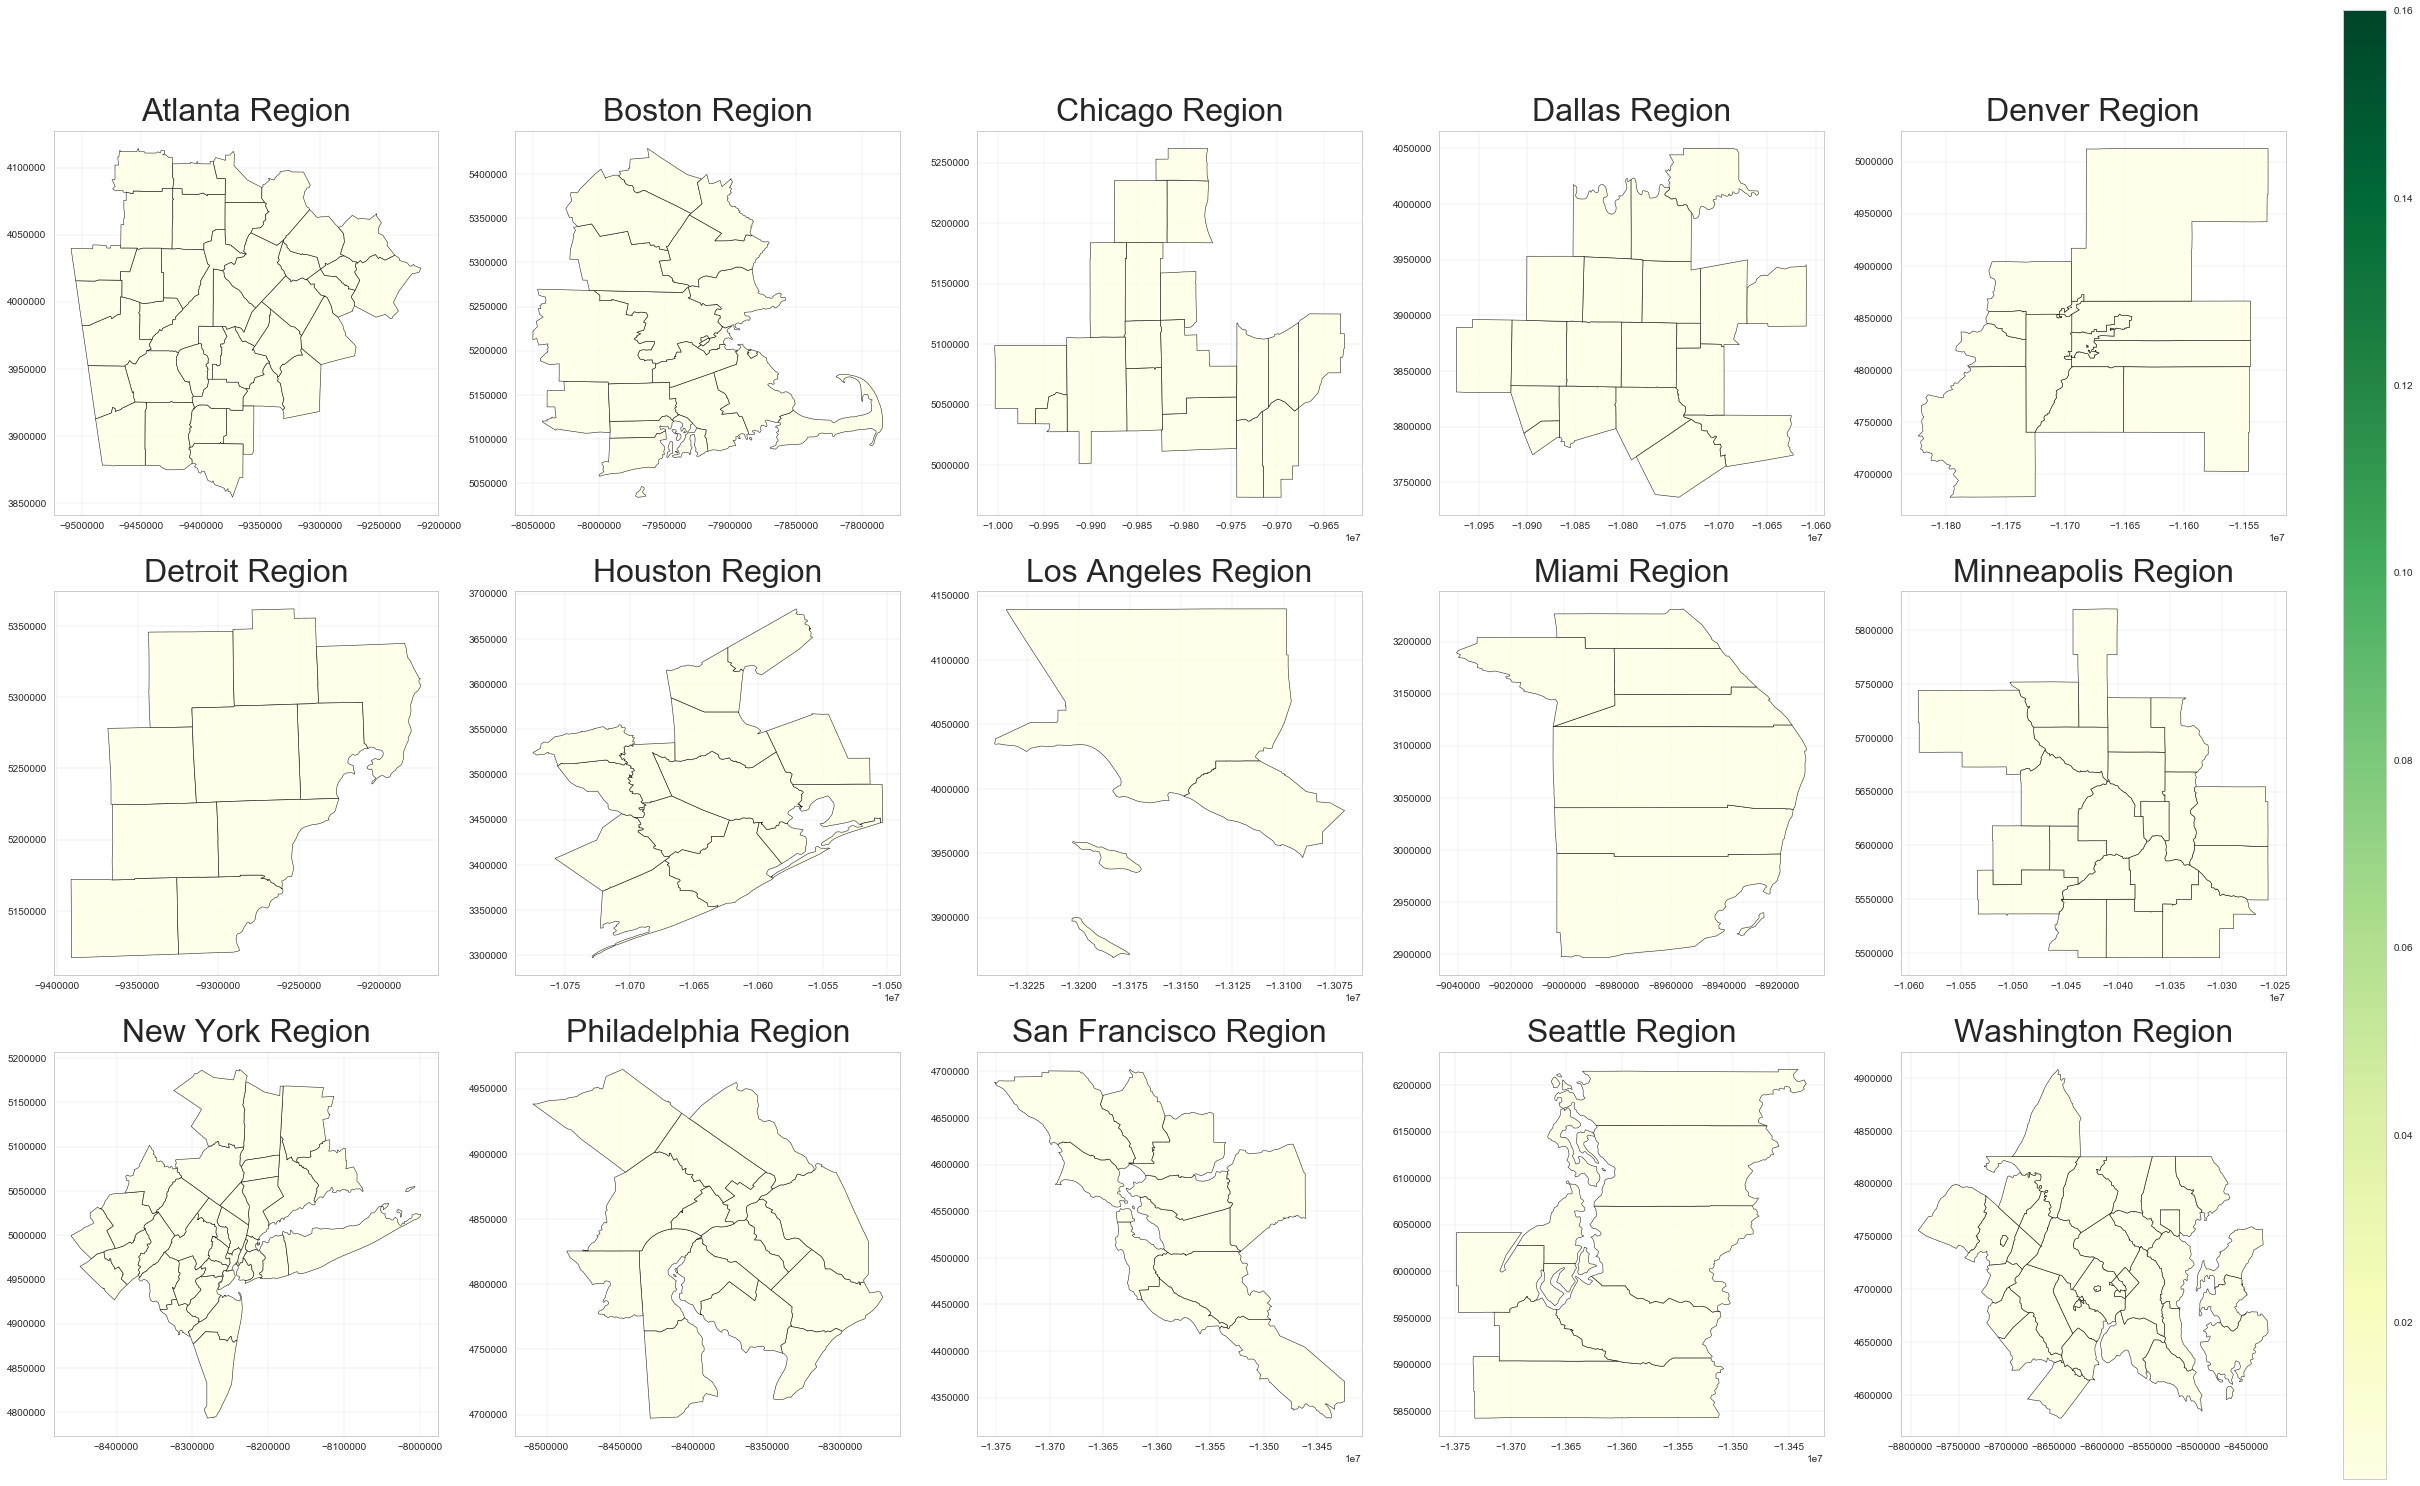

In [699]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = POPchg1017shp['2010-2017'].min(), POPchg1017shp['2010-2017'].max()

cax = fig.add_axes([0.92, 0.1, 0.015, .85])
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical')

# im = axes[0].imshow(my_image1)
# clim=im.properties()['clim']
# axes[1].imshow(my_image2, clim=clim)
# fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)

# 15 choroplets of 15 major US metros
for k in range(len(CSAs.index)):
    ax = fig.add_subplot(3,5,k+1)
    POPchg1017shp[POPchg1017shp['CSA'] == CSAs.index[k]].plot(ax=ax, column= '2010-2017', clim=sm, cmap='YlGn',
                             edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs.index[k]]), fontsize=32, y=1.01)
    ax.grid(linewidth=0.25)

In [736]:
POPchg1017['2010-2017'].groupby([POPchg1017['CSA'], POPchg1017['Name']]).sum().sort_values()

CSA  Name         
220  Detroit          0.003298
176  Chicago          0.006176
428  Philadelphia     0.019667
408  NYC Metro        0.034645
148  Boston           0.043061
348  Los Angeles      0.051004
nan  US Total         0.054997
548  Washington       0.078696
488  San Francisco    0.083900
370  Miami            0.107264
122  Atlanta          0.109243
500  Seattle          0.114619
216  Denver           0.137340
206  Dallas           0.145211
288  Houston          0.160049
378  Minneapolis           NaN
Name: 2010-2017, dtype: float64

----